# 0 SETUP

In [15]:
library(here)
setwd(here())
print(getwd())
source(file="misc_functions.R")
library(lattice)

[1] "/home/sapristi/dev/ML"


In [13]:
train.raw <- read.csv("datasets/titanic_na/train.csv")
train.raw$Survived <- as.factor(train.raw$Survived)
cols.notna <- !is.na(train.raw$Age)
train.notna <- train.raw[cols.notna,]


# 1 Age exploration

## 1.0  Feature creation

We create some rows to approximate age at different resolutions

In [46]:
train.notna$Age.discf1 <- as.factor(sapply(train.notna$Age, function(age){return(as.integer(age / 1))}))
train.notna$Age.discf2 <- as.factor(sapply(train.notna$Age, function(age){return(as.integer(age / 2))}))
train.notna$Age.discf4 <- as.factor(sapply(train.notna$Age, function(age){return(as.integer(age / 4))}))

train.notna$Age.disc1 <- sapply(train.notna$Age, function(age){return(as.integer(age / 1))})
train.notna$Age.disc2 <- sapply(train.notna$Age, function(age){return(as.integer(age / 2))})
train.notna$Age.disc4 <- sapply(train.notna$Age, function(age){return(as.integer(age / 4))})

## 1.1 Density plots : Age | Survived + Sex
Conditional density plot, not very good because we don't see the plot are on a relative scale 

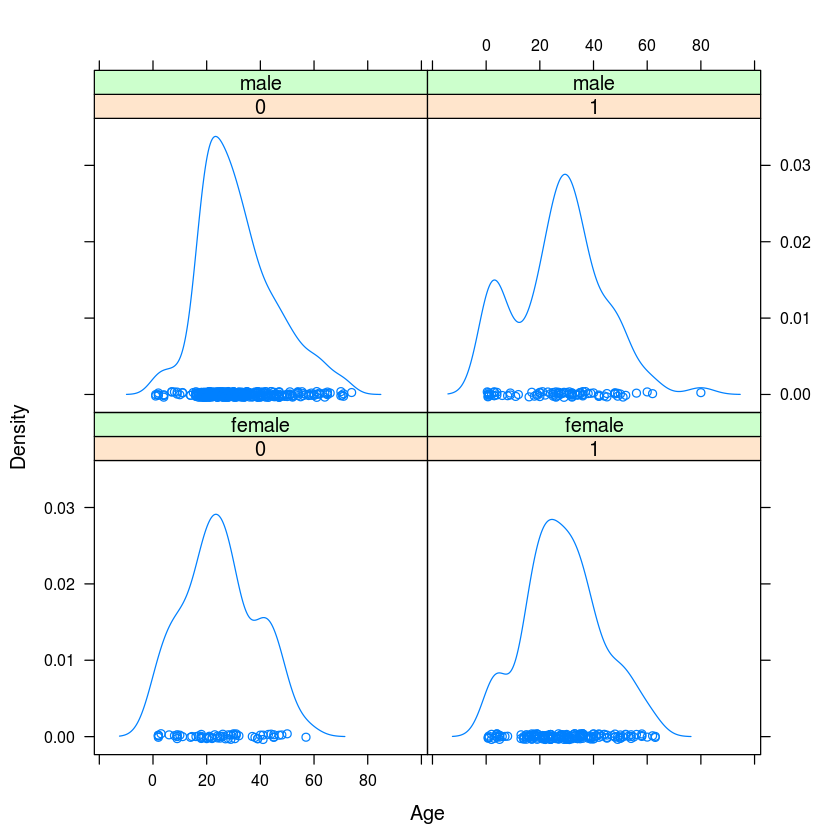

In [34]:
densityplot(~Age| Survived + Sex, data = train.notna)

## 1.2 Histogram plots : Age | Survived + Sex¶

Now this is better, since we can see the count for each age.

We can clealy see some patterns, as well as what we can think of as noise.

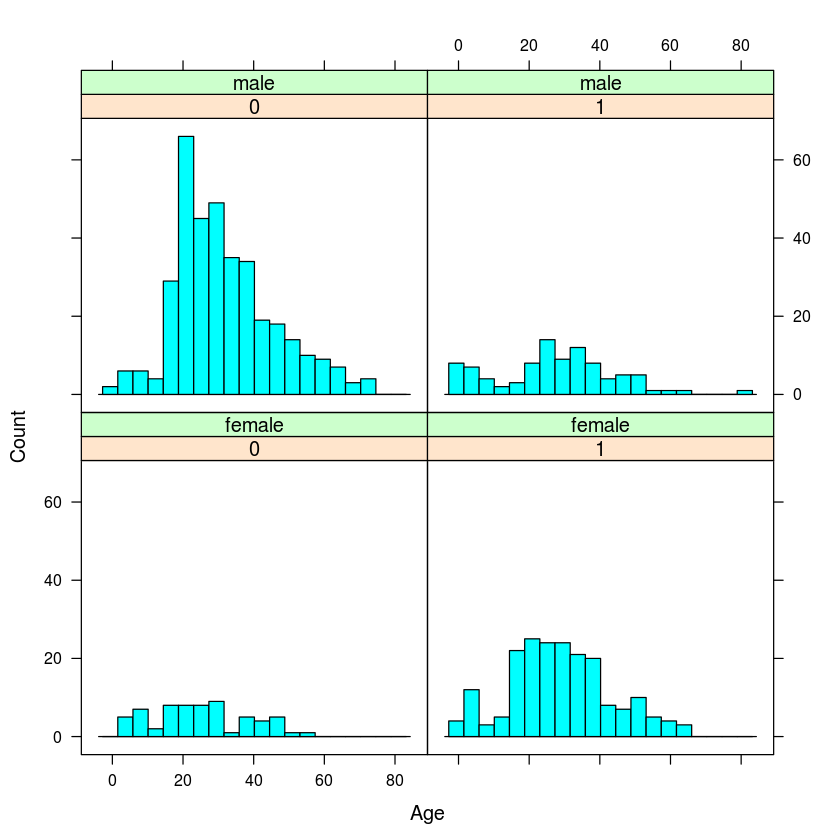

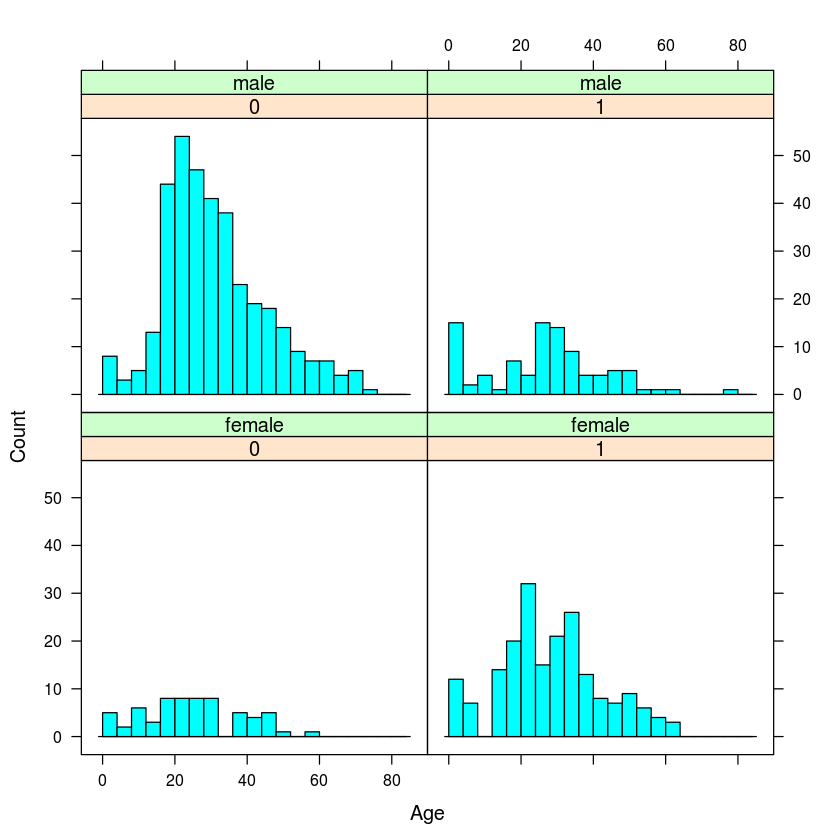

In [44]:
histogram(~Age| Survived + Sex, data = train.notna, type="count", nint=20)
# histogram(~Age.disc1|Survived + Sex, data = train.notna, type="count")
histogram(~Age|Survived + Sex, data = train.notna, type="count", breaks = seq(from=0, to=85, by=4))

## 1.3 Histogram : Survived | Age + Sex

This is quite good as well to see some patterns.

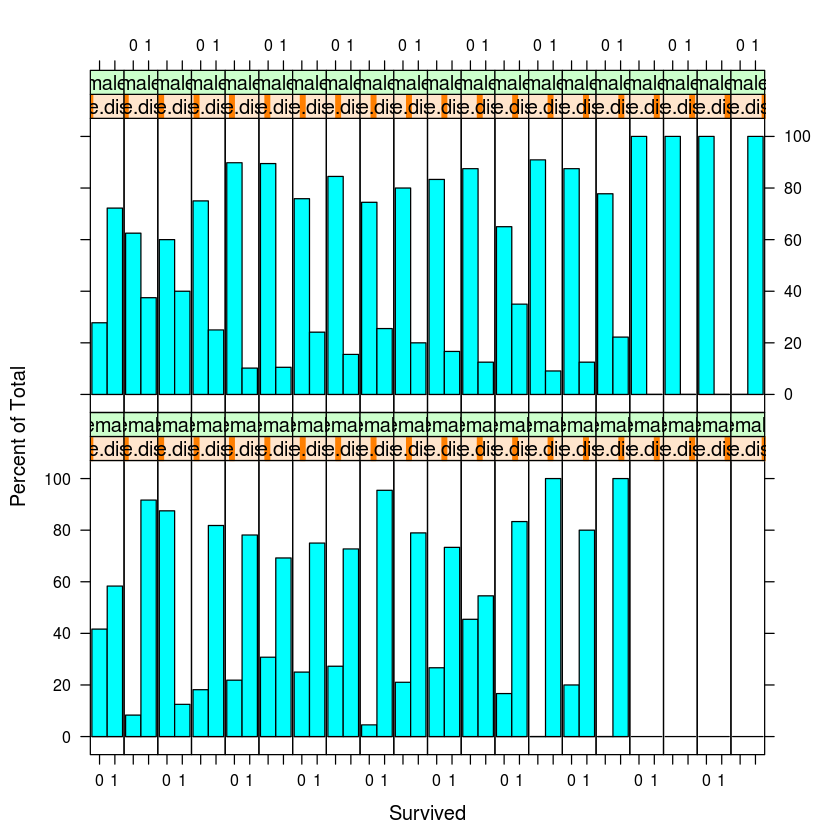

In [47]:
histogram(~Survived | Age.disc4 + Sex , data = train.notna)

From this low-res view, we can group males in 3 categories : 

  - less than 12 : can be saved
  - between 12 and 60 : likely to die
  - more than 60 : will surely die (except from a lone old man ?)
  
For females there is a strange death-surge between 8 and 12 yo, and there is no very clear pattern, except that old females tend to survive quite well.

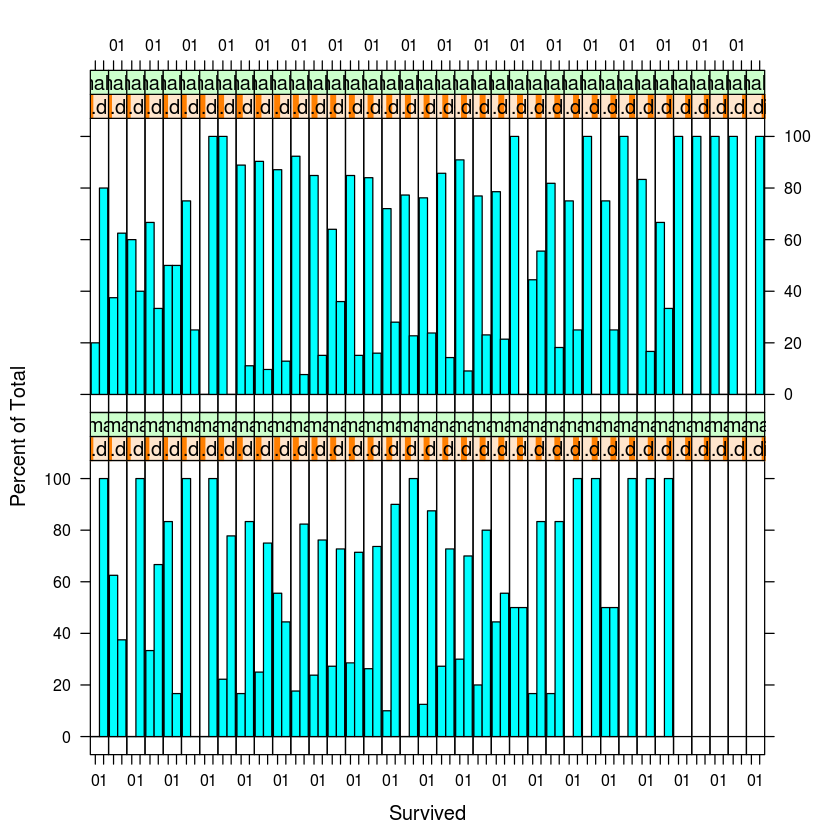

In [48]:
histogram(~Survived | Age.disc2 + Sex , data = train.notna)

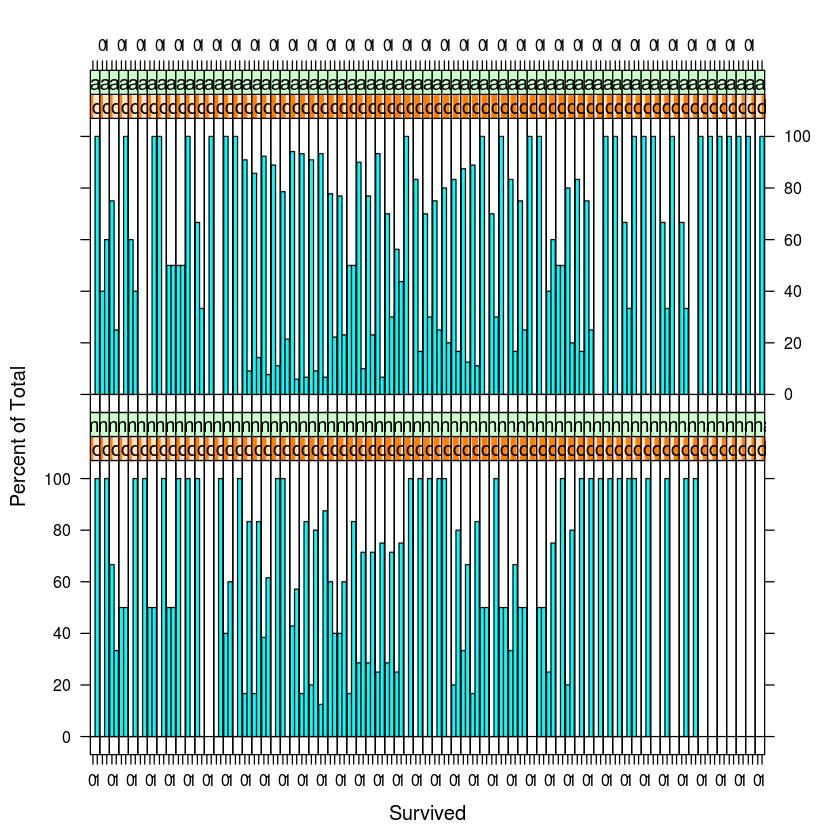

In [49]:
histogram(~Survived | Age.disc1 + Sex , data = train.notna)

## 1.4 Histgram : zooming in

Too much data, lets try to zoom in. We also use `count` histogram type, and can see how little data there is for children.
A good limit for both boys and girls seems to be 15 y.o.

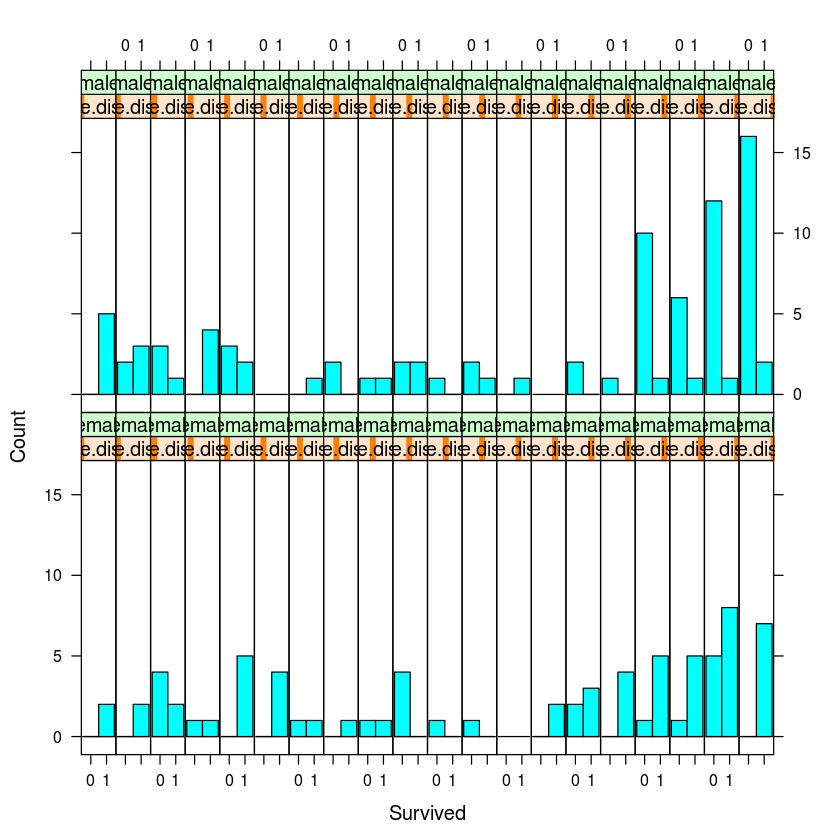

In [51]:
histogram(~Survived | Age.disc1 + Sex , data = train.notna[train.notna$Age.disc1 < 20,], type = "count")

Let's see what happens between 40 and 60 :

We can see a limit for both males and females at about 51 y.o

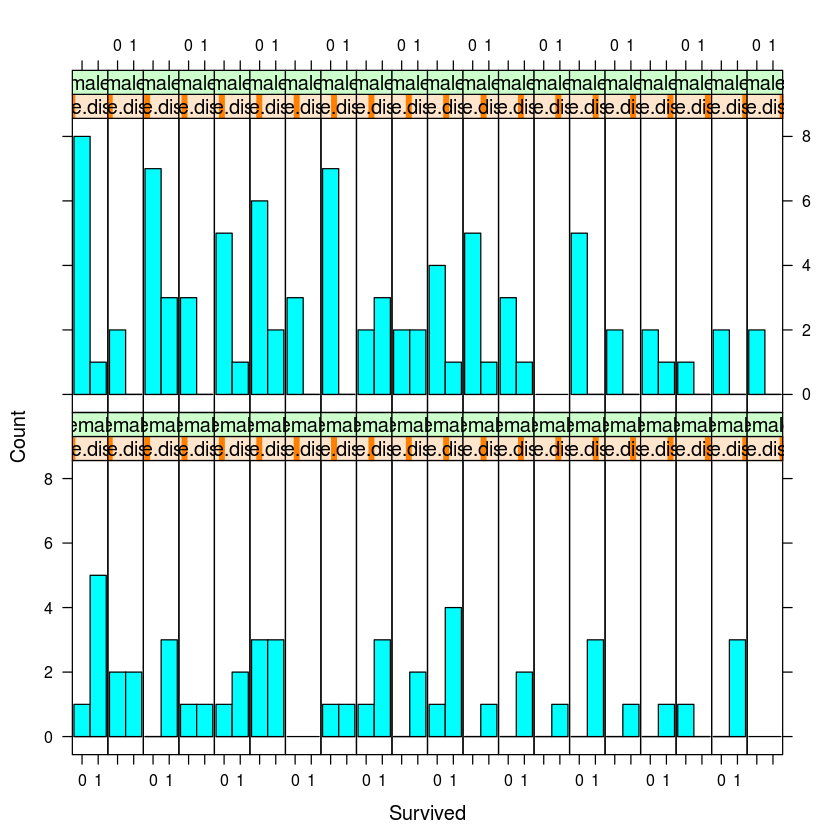

In [59]:
histogram(~Survived | Age.disc1 + Sex , 
          data = train.notna[train.notna$Age.disc1 >= 40 & train.notna$Age.disc1 < 60,], 
          type = "count")

# Conclusion

From what we could see, wa can modify the features in the following way : 
 
  - set Age as an integer, and round < 0 to 1
  - create a feature Age.simple that separates between =< 15, 15 < 51 and > 51
  - create a feature Age.disc with age at resolution 4 or 5